In [1]:
#data preprocessing
import pandas as pd
#produces a prediction model in the form of an ensemble of weak prediction models, typically decision tree
import xgboost as xgb
#the outcome (dependent variable) has only a limited number of possible values. 
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression
#A random forest is a meta estimator that fits a number of decision tree classifiers 
#on various sub-samples of the dataset and use averaging to improve the predictive 
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier
#a discriminative classifier formally defined by a separating hyperplane.
from sklearn.svm import SVC
#displayd data
from IPython.display import display
%matplotlib inline

In [2]:
# Read data and drop redundant column.
data = pd.read_csv('Data/final_processed_3.csv')
display(data.head())


# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100


# Print the results
print ("Total number of matches: {}".format(n_matches))
print ("Number of features: {}".format(n_features))
print ("Number of matches won by home team: {}".format(n_homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

,div,key,team1,team2,date,FTR,team1_home_win,team1_home_draw,team1_away_win,team1_away_draw,...,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,home_player_overall,away_player_overall,home_team_overall,away_team_overall
0,702,Stoke_Hull_2010-04-03,4,7,2010-04-03,H,0.472222,0.277778,0.147059,0.323529,...,18.0,0.00,1.35,1.30,3.60,3.25,66,66,429,431
1,341,Middlesbrough_Man United_2009-05-02,9,19,2009-05-02,A,0.277778,0.444444,0.117647,0.117647,...,18.0,1.00,1.81,1.78,2.15,2.09,65,68,395,420
2,1514,Stoke_Bolton_2012-05-13,4,3,2012-05-13,D,0.447368,0.302632,0.171053,0.250000,...,19.0,-0.25,2.07,2.03,1.89,1.84,68,66,429,467
3,812,Blackpool_Blackburn_2010-09-25,24,6,2010-09-25,A,0.000000,0.500000,0.500000,0.000000,...,22.0,0.00,2.41,2.22,1.68,1.62,64,68,459,501
4,1682,Newcastle_Man City_2012-12-15,20,16,2012-12-15,A,0.393939,0.318182,0.230769,0.276923,...,25.0,0.75,2.05,1.99,1.92,1.87,68,68,430,370


Total number of matches: 3040
Number of features: 95
Number of matches won by home team: 1390
Win rate of home team: 45.72%


In [3]:
# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all =data.drop(['div','FTR', 'key', 'date', 'WHH','WHD','WHA'], axis=1)  # df.columns is zero-based pd.Index
# X_all =X_all.drop(0, axis=1)  # df.columns is zero-based pd.Index 

y_all = data['FTR']

display(X_all.head())
print(X_all.shape)

,team1,team2,team1_home_win,team1_home_draw,team1_away_win,team1_away_draw,team1_home_goals,team1_away_goals,team1_home_goals_conceded,team1_away_goals_conceded,...,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,home_player_overall,away_player_overall,home_team_overall,away_team_overall
0,4,7,0.472222,0.277778,0.147059,0.323529,1.250000,0.735294,0.944444,1.647059,...,18.0,0.00,1.35,1.30,3.60,3.25,66,66,429,431
1,9,19,0.277778,0.444444,0.117647,0.117647,0.888889,0.529412,1.055556,1.882353,...,18.0,1.00,1.81,1.78,2.15,2.09,65,68,395,420
2,4,3,0.447368,0.302632,0.171053,0.250000,1.342105,0.684211,0.973684,1.710526,...,19.0,-0.25,2.07,2.03,1.89,1.84,68,66,429,467
3,24,6,0.000000,0.500000,0.500000,0.000000,1.500000,1.500000,2.000000,2.500000,...,22.0,0.00,2.41,2.22,1.68,1.62,64,68,459,501
4,20,16,0.393939,0.318182,0.230769,0.276923,1.590909,1.015385,1.287879,1.661538,...,25.0,0.75,2.05,1.99,1.92,1.87,68,68,430,370


(3040, 89)


In [4]:
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

# Standardising the data.
from sklearn.preprocessing import scale
cols = X_all.columns

for col in cols:
    X_all[col] = scale(X_all[col])
X_all = preprocess_features(X_all)


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [5]:
### Final  Feature selection algorithms
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import train_test_split

# print(X.shape)
# X = SelectKBest(score_func=f_classif, k="all").fit_transform(X_all,y)

##Final splitting
# X_train, X_test, y_train, y_test = train_test_split(X, y_all, 
#                                                     test_size = 0.2,
#                                                     shuffle = False)

In [9]:
#for measuring training time
from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
#     print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
#     print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return 0,sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
#     print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
#     print (f1, acc)
#     print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))
    return acc

In [10]:
# Initialize the three models (XGBoost is initialized later)
##Final accuracy calculator..with best feature.

# clf_A = LogisticRegression(random_state = 42)
# clf_B = SVC(random_state = 912, kernel='rbf')
# clf_C = xgb.XGBClassifier(seed = 82)

# train_predict(clf_A, X_train, y_train, X_test, y_test)
# print ('')

# train_predict(clf_B, X_train, y_train, X_test, y_test)
# print ('')
# train_predict(clf_C, X_train, y_train, X_test, y_test)
# print ('')



In [11]:
#### Feature selection to find out the best number of features
### Feature selection algorithms
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

def selectFeature(feature, num):
    
    
    # Initialize the three models (XGBoost is initialized later)
    clf_A = LogisticRegression(random_state = 42)
    clf_B = SVC(random_state = 912, kernel='rbf')
    clf_C = xgb.XGBClassifier(seed = 34)
    
    X = SelectKBest(score_func=feature, k=num).fit_transform(X_all,y_all)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_all, 
                                                    test_size = 0.2,
                                                    shuffle = False)
#   
    a1 = train_predict(clf_A, X_train, y_train, X_test, y_test)
#     print ('')
    a2 = train_predict(clf_B, X_train, y_train, X_test, y_test)
#     print ('')
    a3= train_predict(clf_C, X_train, y_train, X_test, y_test)
#     print ('')
    return [a1,a2,a3]


##Running for different features
features = [mutual_info_classif]
all_accuracies = []
x_points =[]
y_modelAccuracies = [[],[],[]]
# for f in features:
#     temp =[]
for num in range(10,X_all.shape[1]):
    x_points.append(num)
    a1,a2,a3 = selectFeature(f_classif,num)
    y_modelAccuracies[0].append(a1 * 100)
    y_modelAccuracies[1].append(a2 * 100)
    y_modelAccuracies[2].append(a3 * 100)
    
print("points", x_points)  
print("y_models", y_modelAccuracies)  

# print("The Max accuracy is ", max(temp), " for number ", temp.index(max(temp))+10)
# all_accuracies.append((f, temp))


F1 score and accuracy score for test set: 0.0000 , 0.6151.
F1 score and accuracy score for test set: 0.0000 , 0.6003.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6036.
F1 score and accuracy score for test set: 0.0000 , 0.6168.
F1 score and accuracy score for test set: 0.0000 , 0.5954.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6003.
F1 score and accuracy score for test set: 0.0000 , 0.6135.
F1 score and accuracy score for test set: 0.0000 , 0.5970.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.5954.
F1 score and accuracy score for test set: 0.0000 , 0.6184.
F1 score and accuracy score for test set: 0.0000 , 0.5987.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.5987.
F1 score and accuracy score for test set: 0.0000 , 0.6201.
F1 score and accuracy score for test set: 0.0000 , 0.6003.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6053.
F1 score and accuracy score for test set: 0.0000 , 0.6168.
F1 score and accuracy score for test set: 0.0000 , 0.6135.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6168.
F1 score and accuracy score for test set: 0.0000 , 0.6118.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6217.
F1 score and accuracy score for test set: 0.0000 , 0.6135.
F1 score and accuracy score for test set: 0.0000 , 0.6151.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6118.
F1 score and accuracy score for test set: 0.0000 , 0.6151.
F1 score and accuracy score for test set: 0.0000 , 0.6168.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6151.
F1 score and accuracy score for test set: 0.0000 , 0.6135.
F1 score and accuracy score for test set: 0.0000 , 0.6184.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6201.
F1 score and accuracy score for test set: 0.0000 , 0.6201.
F1 score and accuracy score for test set: 0.0000 , 0.6069.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6217.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6151.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6316.
F1 score and accuracy score for test set: 0.0000 , 0.6168.
F1 score and accuracy score for test set: 0.0000 , 0.6234.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6299.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6414.
F1 score and accuracy score for test set: 0.0000 , 0.6217.
F1 score and accuracy score for test set: 0.0000 , 0.6234.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6480.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6234.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6398.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6447.
F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6266.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6414.
F1 score and accuracy score for test set: 0.0000 , 0.6382.
F1 score and accuracy score for test set: 0.0000 , 0.6234.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6414.
F1 score and accuracy score for test set: 0.0000 , 0.6398.
F1 score and accuracy score for test set: 0.0000 , 0.6250.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6447.
F1 score and accuracy score for test set: 0.0000 , 0.6365.
F1 score and accuracy score for test set: 0.0000 , 0.6283.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6382.
F1 score and accuracy score for test set: 0.0000 , 0.6382.
F1 score and accuracy score for test set: 0.0000 , 0.6349.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6398.
F1 score and accuracy score for test set: 0.0000 , 0.6266.
F1 score and accuracy score for test set: 0.0000 , 0.6382.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6349.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6332.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6266.
F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6398.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6316.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6398.
F1 score and accuracy score for test set: 0.0000 , 0.6332.
F1 score and accuracy score for test set: 0.0000 , 0.6266.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6431.
F1 score and accuracy score for test set: 0.0000 , 0.6332.
F1 score and accuracy score for test set: 0.0000 , 0.6234.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6464.
F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6299.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6447.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6266.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6431.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6316.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6398.
F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6299.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6497.
F1 score and accuracy score for test set: 0.0000 , 0.6266.
F1 score and accuracy score for test set: 0.0000 , 0.6250.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6480.
F1 score and accuracy score for test set: 0.0000 , 0.6316.
F1 score and accuracy score for test set: 0.0000 , 0.6316.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6530.
F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6628.
F1 score and accuracy score for test set: 0.0000 , 0.6151.
F1 score and accuracy score for test set: 0.0000 , 0.6283.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6497.
F1 score and accuracy score for test set: 0.0000 , 0.6217.
F1 score and accuracy score for test set: 0.0000 , 0.6332.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6431.
F1 score and accuracy score for test set: 0.0000 , 0.6217.
F1 score and accuracy score for test set: 0.0000 , 0.6299.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6530.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6299.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6513.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6283.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6464.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6283.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6464.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6250.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6398.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6250.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6398.
F1 score and accuracy score for test set: 0.0000 , 0.6332.
F1 score and accuracy score for test set: 0.0000 , 0.6250.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6447.
F1 score and accuracy score for test set: 0.0000 , 0.6316.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6464.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6266.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6316.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6398.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6299.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6464.
F1 score and accuracy score for test set: 0.0000 , 0.6332.
F1 score and accuracy score for test set: 0.0000 , 0.6283.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6530.
F1 score and accuracy score for test set: 0.0000 , 0.6365.
F1 score and accuracy score for test set: 0.0000 , 0.6266.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6447.
F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6283.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6431.
F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6382.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6283.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6431.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6250.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6414.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6480.
F1 score and accuracy score for test set: 0.0000 , 0.6217.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6447.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6234.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6480.
F1 score and accuracy score for test set: 0.0000 , 0.6266.
F1 score and accuracy score for test set: 0.0000 , 0.6283.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6464.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6266.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6497.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6266.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6382.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6480.
F1 score and accuracy score for test set: 0.0000 , 0.6266.
F1 score and accuracy score for test set: 0.0000 , 0.6250.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6431.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6447.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6201.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6447.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6497.
F1 score and accuracy score for test set: 0.0000 , 0.6217.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6382.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6234.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6398.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6234.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6431.
F1 score and accuracy score for test set: 0.0000 , 0.6168.
F1 score and accuracy score for test set: 0.0000 , 0.6102.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6447.
F1 score and accuracy score for test set: 0.0000 , 0.6168.
F1 score and accuracy score for test set: 0.0000 , 0.6118.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6480.
F1 score and accuracy score for test set: 0.0000 , 0.6135.
F1 score and accuracy score for test set: 0.0000 , 0.6118.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6398.
F1 score and accuracy score for test set: 0.0000 , 0.6102.
F1 score and accuracy score for test set: 0.0000 , 0.6118.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6102.
F1 score and accuracy score for test set: 0.0000 , 0.6069.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6414.
F1 score and accuracy score for test set: 0.0000 , 0.6118.
F1 score and accuracy score for test set: 0.0000 , 0.6102.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6464.
F1 score and accuracy score for test set: 0.0000 , 0.6135.
F1 score and accuracy score for test set: 0.0000 , 0.6102.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6414.
F1 score and accuracy score for test set: 0.0000 , 0.6069.
F1 score and accuracy score for test set: 0.0000 , 0.6102.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6365.
F1 score and accuracy score for test set: 0.0000 , 0.6102.
F1 score and accuracy score for test set: 0.0000 , 0.6086.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6431.
F1 score and accuracy score for test set: 0.0000 , 0.6135.
F1 score and accuracy score for test set: 0.0000 , 0.6086.
F1 score and accuracy score for test set: 0.0000 , 0.6431.
points [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
y_models [[0.6151315789473685, 0.6167763157894737, 0.6134868421052632, 0.618421052631579, 0.6200657894736842, 0.6167763157894737, 0.6167763157894737, 0.6134868421052632, 0.6151315789473685, 0.6134868421052632, 0.6200657894736842, 0.625, 0.6167763157894737, 0.6233552631578947, 0.6217105263157895, 0.6233552631578947, 0.6398026315789473, 0.6348684210526315, 0.6381578947368421, 0.6398026315789473, 0.6365131578947368, 0.6381578947368421, 0.6

/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


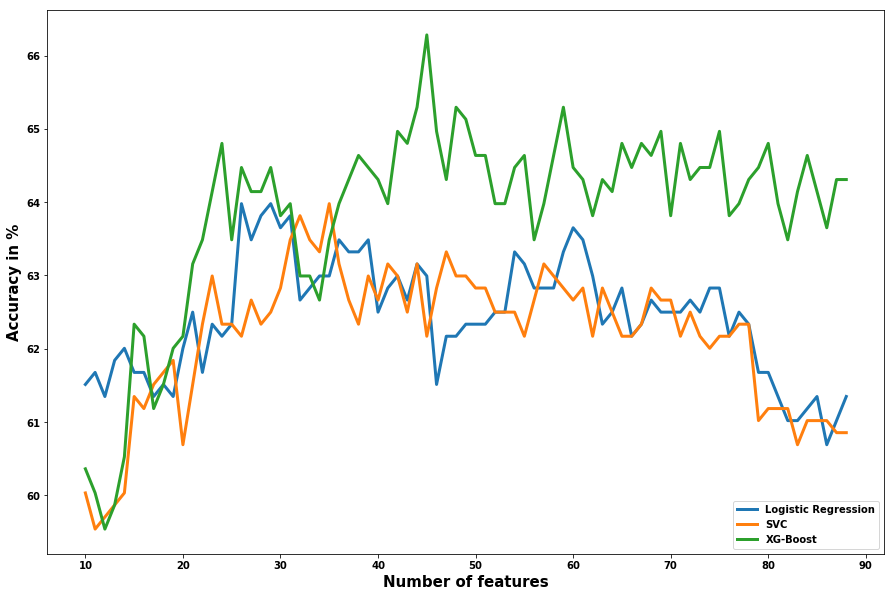

In [34]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams["font.weight"] = "bold"

fig=plt.figure(figsize=(15,10))
plt.plot(x_points,  y_modelAccuracies[0],   label="Logistic Regression",linewidth=3.0)
plt.plot(x_points,  y_modelAccuracies[1],   label="SVC", linewidth=3.0)
plt.plot(x_points,  y_modelAccuracies[2],   label="XG-Boost", linewidth=3.0)

plt.legend(loc='lower right')
# plt.title("Accuracy vs Features using f_Classif", fontsize=20, fontweight="bold")
plt.xlabel("Number of features", fontsize=15, fontweight="bold")
plt.ylabel("Accuracy in %", fontsize=15, fontweight="bold")

fig.savefig('f_classif.png')

plt.show()



In [148]:
# ###Trying to optimize the hyperparameter
# # TODO: Import 'GridSearchCV' and 'make_scorer'
# from sklearn.grid_search import GridSearchCV
# from sklearn.metrics import make_scorer


# # TODO: Create the parameters list you wish to tune
# parameters = { 'learning_rate' : [0.1],
#                'n_estimators' : [40],
#                'max_depth': [3],
#                'min_child_weight': [3],
#                'gamma':[0.4],
#                'subsample' : [0.8],
#                'colsample_bytree' : [0.8],
#                'scale_pos_weight' : [1],
#                'reg_alpha':[1e-5]
#              }  

# # TODO: Initialize the classifier
# clf = xgb.XGBClassifier(seed=2)

# # TODO: Make an f1 scoring function using 'make_scorer' 
# f1_scorer = make_scorer(f1_score,pos_label='H',average='micro')

# # TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
# grid_obj = GridSearchCV(clf,
#                         scoring=f1_scorer,
#                         param_grid=parameters,
#                         cv=5)

# # TODO: Fit the grid search object to the training data and find the optimal parameters
# grid_obj = grid_obj.fit(X_train,y_train)

# # Get the estimator
# clf = grid_obj.best_estimator_
# print (clf)

# # Report the final F1 score for training and testing after parameter tuning
# f1, acc = predict_labels(clf, X_train, y_train)
# print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
# f1, acc = predict_labels(clf, X_test, y_test)
# print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1045: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1045: UserWarning: Note that pos_label (set to 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=3, missing=None,
       n_estimators=40, n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=2, silent=True, subsample=0.8)
F1 score and accuracy score for training set: 0.0000 , 0.6809.
F1 score and accuracy score for test set: 0.0000 , 0.6447.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
